Heidi Putkuri - 01496544

I have used vscode github copilot to generate and autofill some of the codes

In [1]:
import sys
!{sys.executable} -m pip install --user gplearn
!{sys.executable} -m pip install --user sympy

In [2]:
!{sys.executable} -m pip install --user pip pysr


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline
from gplearn.genetic import SymbolicRegressor
from sympy import *
from utils import *

import random
import warnings
warnings.filterwarnings('ignore')

# Lotka-Volterra prey-predator dynamics

This example is adapted from Martin et al. (2018) Reverse-engineering ecological theory from data. 
https://doi.org/10.1098/rspb.2018.0422

Prey-predator population dynamics are governed by Lotka-Volterra equations:

$\frac{dP}{dt} = \beta_1 P - \beta_2 PD$

$\frac{dD}{dt} = -\beta_3 D + \beta_4 PD$

Here, $P$ and $D$ are the prey and predator population sizes respectively, $t$ is time and $\frac{dP}{dt}$ and $\frac{dD}{dt}$ are instantaneous growth rates of the respective populations. The model parameters are:

$\beta_1$: growth rate of prey in the absence of predation;

$\beta_2$: death rate of prey with predation;

$\beta_3$: death rate of predators in the absence of prey;

$\beta_4$: growth rate of the predators in the presence of prey.

Simulation of prey-predator population dynamics with Lotka-Volterra equations:

In [4]:
def generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0, noise=True):
    """
    Generates a simulated dataset using simple Lotka-Volterra dynamics.
    
    Parameters
    ----------
    
    max_time : maximum time to simulate until
    dt : time step for the simulation
    b1 : beta_1
    b2 : beta_2
    b3 : beta_3
    b4 : beta_4
    t0 : start time
    p0 : initial prey population size
    p1 : initial predator population size
    noise : boolean indicating whether to add some noise to the data
    
    Returns
    -------
    
    t_h : time vector
    p_h : prey population sizes
    d_h : predator population sizes
    """
    
    # Initial values
    t = t0
    p = p0
    d = d0

    # Histories
    t_h = [t]
    p_h = [p]
    d_h = [d]

    while t < max_time:
        t = t + dt
        p = p + (b1*p - b2*p*d)*dt
        d = d + (-b3*d + b4*p*d)*dt

        t_h.append(t)
        p_h.append(p)
        d_h.append(d)
    
    t_h = np.array(t_h)
    p_h = np.array(p_h)
    d_h = np.array(d_h)
    if noise:
        p_h = p_h + np.random.normal(loc=0, scale=0.1, size=len(t_h))
        d_h = d_h + np.random.normal(loc=0, scale=0.1, size=len(t_h))
        
    p_h[p_h < 0] = 0
    d_h[d_h < 0] = 0

    return t_h, p_h, d_h


def derivative(p, d, b1, b2, b3, b4):
    """
    Returns the derivative of Lotka-Volterra equations. 
    """
    
    return np.array([p*(b1 - b2*d), d*(-b3 + b4*p)])

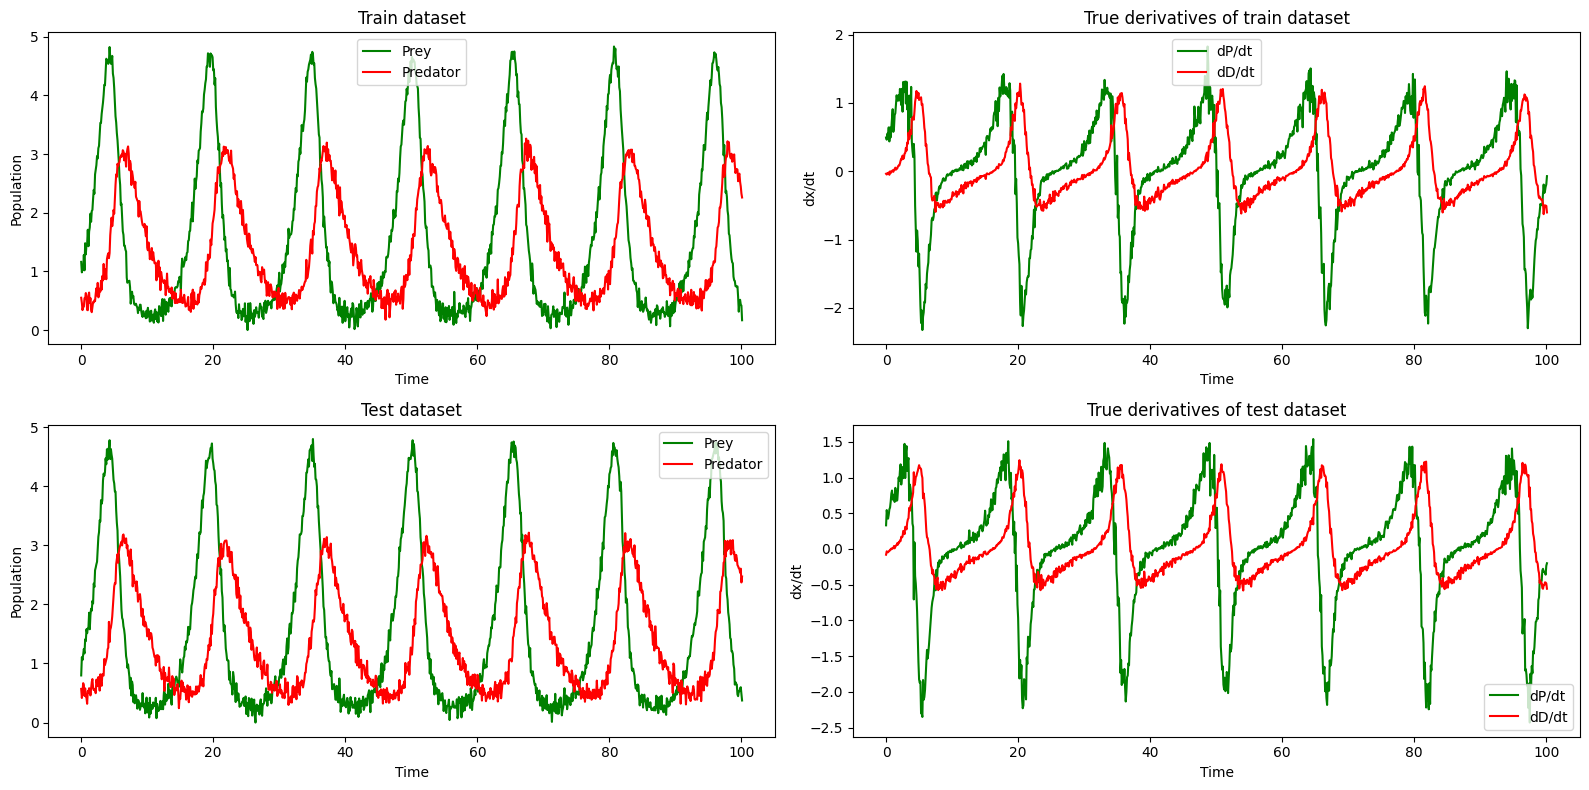

In [5]:
np.random.seed(1)
max_time = 100
dt = 0.1
b1 = 0.7
b2 = 0.5
b3 = 0.3
b4 = 0.2
t0 = 0
p0 = 1
d0 = 0.5

# here we generate the data for the train and test datasets

t_train, p_train, d_train = generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0)
t_test, p_test, d_test = generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0)

# we also calculate the true derivatives for the train and test datasets
# these will be used to evaluate the performance of the models
# true derivatives are calculated using the Lotka-Volterra equations
# der_train is the true derivative of the train dataset
# der_test is the true derivative of the test dataset
der_train = derivative(p_train, d_train, b1, b2, b3, b4) 
der_test = derivative(p_test, d_test, b1, b2, b3, b4)

# we stack the prey and predator populations to form the input data
# this is done by stacking the prey and predator populations as columns
x_train = np.vstack([p_train, d_train]).T # stacks array in sequence vertically (row wise)
x_test = np.vstack([p_test, d_test]).T

plt.subplots(2, 2, figsize=(16, 8))

plt.subplot(221)
plt.plot(t_train, p_train, 'green', label="Prey")
plt.plot(t_train, d_train, 'red', label="Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Train dataset")

plt.subplot(222)
plt.plot(t_train, der_train[0], 'green', label="dP/dt") # # der_train[0] is the derivative of prey
plt.plot(t_train, der_train[1], 'red', label="dD/dt") # # der_train[1] is the derivative of predator
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.title("True derivatives of train dataset")

plt.subplot(223)
plt.plot(t_test, p_test, 'green', label="Prey")
plt.plot(t_test, d_test, 'red', label="Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Test dataset")

plt.subplot(224)
plt.plot(t_test, der_test[0], 'green', label="dP/dt")
plt.plot(t_test, der_test[1], 'red', label="dD/dt")
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.title("True derivatives of test dataset")
plt.tight_layout()
plt.show()

### Problem 1: Discovering the mathematical relationships between variables and response in simulated data

First, let's assume we do not know the generative model. We generate the prey-predator data and use some method to infer derivatives, e.g., using cubic splines, using just the population data.

### notes

Cubic splines are used to estimate the derivatives of the prey and predator populations. The derivatives are then used to estimate the parameters of the Lotka-Volterra equations. 

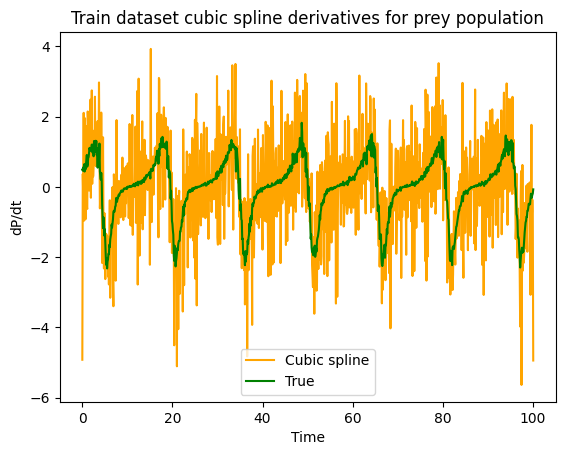

In [6]:
y_cs_p = CubicSpline(t_train, p_train)(t_train, 1)  # First order derivatives of the PREY population
# the parameter 1 indicates the order of the derivative
plt.figure()
plt.plot(t_train, y_cs_p, "orange", label="Cubic spline")
plt.plot(t_train, der_train[0], "green", label="True") # True derive of the prey population 
plt.xlabel("Time")
plt.ylabel("dP/dt")
plt.title("Train dataset cubic spline derivatives for prey population")
plt.legend()
plt.show()

Calculation of derivative induces some noise -- let's see how SR fares.

Let's use **gplearn** implementation of symbolic regression for *Python*: https://gplearn.readthedocs.io/en/stable/

This implementation only allows one equation to be returned instead of a set (unlike most other SR packages), so let's train 10 models:

In [7]:
def SR(x_train, y_train, x_test, y_test, method, pc, n, rng, population_size=3000, generations=20):
    """
    A helper function to run n instances of the gplearn symbolic regressor.
    
    Parameters
    ----------
    
    x_train : train population sizes of both prey or predator (n_samples x 2 matrix)
    y_train : train response (the derivatives or population sizes) for either prey or predator (an array)
    x_test : test population sizes
    y_test : test responses
    method : initialization method (see gplearn documentation)
    pc : parsimony coefficient (see gplearn documentation)
    rng : random seed value
    population_size: the size of the symbolic representation population (see gplearn documentation)
    generations : number of iterations (see gplearn documentation)
    
    Returns
    -------
    
    pandas DataFrame with test scores, equation lengths and equations.
    """

    eqs = []
    test_scores = []
    lengths = []
    for i in range(n):                                                     
        est_gp = SymbolicRegressor(feature_names=["p", "d"],            # Variable symbols
                                   verbose=0,                           # Disable full output
                                   function_set=["add", "mul", "div"],  # The alphabet (or library) of mathematical expressions
                                   population_size=population_size,     # Population size for GP algorithm
                                   generations=generations,             # Number of generations
                                   parsimony_coefficient=pc,            # Penalty for long equations (prefer smaller models)
                                   init_method=method,                  # Method of tree initialization, varying results
                                   max_samples=0.9,                     # 10% of samples are for validation
                                   random_state=rng[i])

        est_gp.fit(x_train, y_train)                                   # We fit the data to the SR model
        eq = str(est_gp)                                   # We get the final equation
        test_score = np.round(est_gp.score(x_test, y_test), 2)  # Let's compare test dataset output to the true test derivatives
        length = est_gp.run_details_['best_length'][-1]    # Complexity of the best equation
        
        print("Model " + str(i+1) + ", R^2 score: " + str(test_score) + ", " + str(eq))
        eqs.append(eq)
        test_scores.append(test_score)
        lengths.append(length)
       
    return pd.DataFrame({"Test R^2": test_scores, "Length": lengths, "Equation": eqs})

In [9]:
eqs_p = SR(x_train, y_cs_p, x_test, der_test[0], n=10, rng=range(10), method="grow", pc=0.001)
eqs_p

Model 1, R^2 score: 0.97, add(mul(add(add(d, d), mul(d, d)), mul(mul(d, -0.025), mul(p, 0.831))), div(p, add(add(d, d), add(d, 0.967))))
Model 2, R^2 score: 0.99, mul(add(div(mul(-0.182, p), div(0.267, d)), p), add(-0.190, 0.923))
Model 3, R^2 score: 0.98, div(add(add(p, mul(mul(d, d), mul(p, -0.441))), -0.392), add(d, div(0.268, 0.242)))
Model 4, R^2 score: 0.97, mul(add(div(-0.271, -0.789), mul(p, div(d, d))), add(0.562, mul(-0.383, d)))
Model 5, R^2 score: 0.94, mul(add(0.816, mul(-0.613, d)), p)
Model 6, R^2 score: 0.99, mul(0.850, mul(0.850, mul(p, add(mul(-0.639, d), 0.850))))
Model 7, R^2 score: 0.97, add(p, mul(p, add(mul(-0.317, add(d, mul(mul(0.155, d), d))), -0.488)))
Model 8, R^2 score: 1.0, mul(p, add(0.720, mul(-0.509, d)))
Model 9, R^2 score: 0.98, mul(add(mul(-0.467, d), 0.599), p)
Model 10, R^2 score: 0.99, add(mul(mul(d, p), -0.345), div(p, add(0.982, d)))


,Test R^2,Length,Equation
0,0.97,25,"add(mul(add(add(d, d), mul(d, d)), mul(mul(d, ..."
1,0.99,13,"mul(add(div(mul(-0.182, p), div(0.267, d)), p)..."
2,0.98,17,"div(add(add(p, mul(mul(d, d), mul(p, -0.441)))..."
3,0.97,15,"mul(add(div(-0.271, -0.789), mul(p, div(d, d))..."
4,0.94,7,"mul(add(0.816, mul(-0.613, d)), p)"
5,0.99,11,"mul(0.850, mul(0.850, mul(p, add(mul(-0.639, d..."
6,0.97,15,"add(p, mul(p, add(mul(-0.317, add(d, mul(mul(0..."
7,1.00,7,"mul(p, add(0.720, mul(-0.509, d)))"
8,0.98,7,"mul(add(mul(-0.467, d), 0.599), p)"
9,0.99,11,"add(mul(mul(d, p), -0.345), div(p, add(0.982, ..."


We see that the equations are not easily readable, furthermore, they can be simplified. Let's use **SymPy** to simplify the expressions. Unfortunately, SymPy does not define division or subtraction the usual way (rather, they are represented through multiplication and addition, see https://docs.sympy.org/latest/tutorial/manipulation.html) so we need to convert the expression to accomodate for that (our provided custom functions will do that job, i.e., *convert_s* from utils).

In [10]:

p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in eqs_p["Equation"]:
    print(simplify(convert_s(eq)))

p*(-0.020775*d**2*(d + 2)*(3*d + 0.967) + 1)/(3*d + 0.967)
p*(0.733 - 0.499647940074906*d)
(-0.441*d**2*p + p - 0.392)/(d + 1.10743801652893)
-(0.383*d - 0.562)*(p + 0.343472750316857)
p*(0.816 - 0.613*d)
p*(0.614125 - 0.4616775*d)
p*(-0.049135*d**2 - 0.317*d + 0.512)
p*(0.72 - 0.509*d)
p*(0.599 - 0.467*d)
p*(-0.345*d*(d + 0.982) + 1)/(d + 0.982)


Here we get a really nice and elegant output. It may be obvious already -- most of these are indeed one of the Lotka-Volterra equations in predator-prey population dynamics: 

$\frac{dP}{dt} = \beta_1 P - \beta_2 PD = P(\beta_1−\beta_2 D)$

To be exact, this equation represents prey population -- exactly as we had hoped to find. Not only we found the exact underlying mechanics of the prey population dynamics *de novo*, but at the same time we inferred its parameters as well: $\beta_1$ and $\beta_2$. They are quite close to the true parameter values as well (0.7 and 0.5)!

Let's display the 8-th equation in a pretty format, evaluate it and visualize the results:

In [11]:

eq = simplify(convert_s(eqs_p["Equation"][7]))
eq

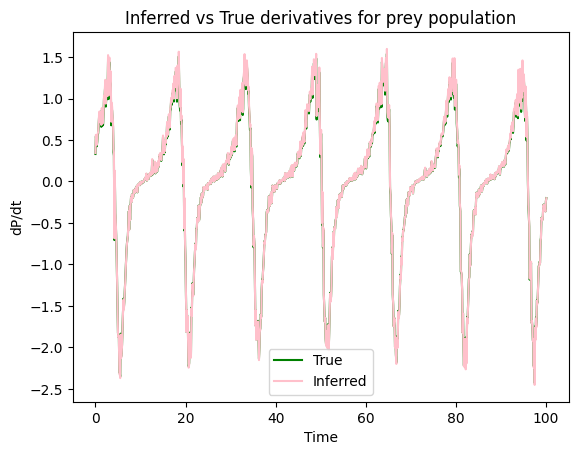

In [13]:

p = p_test
d = d_test
y_sol = eval(str(eq))

plt.figure()
plt.plot(t_test, der_test[0], "green", label="True")
plt.plot(t_test, y_sol, "pink", label="Inferred")
plt.xlabel("Time")
plt.ylabel("dP/dt")
plt.title("Inferred vs True derivatives for prey population")
plt.legend()
plt.show()

Beautiful results! Symbolic regression was not at all confused by the added noise from cubic spline derivative computation.

#### Problem 1a:

Run 10 instances of the symbolic regressor for the simulated PREDATOR population and check the resulting equations. Can you see good solutions? If so, pick out your favorite and report it, visualizing the inferred fit versus the true data.

Hint: remember to compute first order derivatives of the predator population.

#### Code and answers:

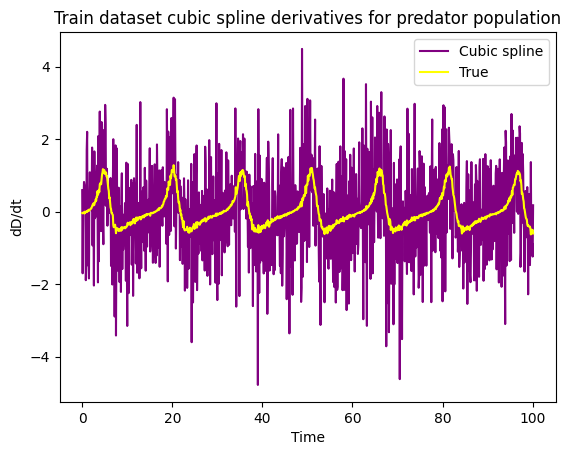

In [14]:
# generating the Simulation of prey-predator population dynamics with Lotka-Volterra equations:
y_cs_d = CubicSpline(t_train, d_train)(t_train, 1)  # First order derivatives of the PREDATOR population

plt.figure()
plt.plot(t_train, y_cs_d, "purple", label="Cubic spline")
plt.plot(t_train, der_train[1], "yellow", label="True")
plt.xlabel("Time")
plt.ylabel("dD/dt")
plt.title("Train dataset cubic spline derivatives for predator population")
plt.legend()
plt.show()



In [15]:
der_test

array([[ 0.33108721,  0.54426366,  0.46882397, ..., -0.35974948,
        -0.23487248, -0.19984236],
       [-0.08002497, -0.03276756, -0.04544852, ..., -0.46983868,
        -0.48168904, -0.55659348]])

In [16]:
# get the equation using the symbolic regressor from 10 different runs
eqs_pred = SR(x_train, y_cs_d, x_test, der_test[1], n=10, rng=range(10), method="grow", pc=0.001)
eqs_pred


Model 1, R^2 score: 0.99, mul(mul(0.182, d), add(add(-0.902, -0.544), p))
Model 2, R^2 score: 0.86, mul(d, mul(add(-0.943, p), 0.160))
Model 3, R^2 score: 0.8, add(mul(add(p, 0.661), 0.309), -0.606)
Model 4, R^2 score: 0.94, mul(d, add(-0.142, add(-0.142, mul(p, 0.226))))
Model 5, R^2 score: 0.78, add(mul(0.222, p), -0.291)
Model 6, R^2 score: 0.98, mul(add(-0.372, add(-0.928, p)), mul(d, 0.189))
Model 7, R^2 score: 0.81, add(-0.459, mul(0.270, p))
Model 8, R^2 score: 0.7, mul(0.214, add(-0.880, p))
Model 9, R^2 score: 0.93, mul(add(-0.620, add(p, -0.836)), mul(d, 0.148))
Model 10, R^2 score: 0.56, mul(p, mul(0.051, p))


,Test R^2,Length,Equation
0,0.99,9,"mul(mul(0.182, d), add(add(-0.902, -0.544), p))"
1,0.86,7,"mul(d, mul(add(-0.943, p), 0.160))"
2,0.80,7,"add(mul(add(p, 0.661), 0.309), -0.606)"
3,0.94,9,"mul(d, add(-0.142, add(-0.142, mul(p, 0.226))))"
4,0.78,5,"add(mul(0.222, p), -0.291)"
5,0.98,9,"mul(add(-0.372, add(-0.928, p)), mul(d, 0.189))"
6,0.81,5,"add(-0.459, mul(0.270, p))"
7,0.70,5,"mul(0.214, add(-0.880, p))"
8,0.93,9,"mul(add(-0.620, add(p, -0.836)), mul(d, 0.148))"
9,0.56,5,"mul(p, mul(0.051, p))"


In [17]:
# simplify all the equations
p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in eqs_pred["Equation"]:
    print(simplify(convert_s(eq)))




0.182*d*(p - 1.446)
d*(0.16*p - 0.15088)
0.309*p - 0.401751
d*(0.226*p - 0.284)
0.222*p - 0.291
0.189*d*(p - 1.3)
0.27*p - 0.459
0.214*p - 0.18832
0.148*d*(p - 1.456)
0.051*p**2


In [18]:
# the equation with the highest R^2 score and the shortest length
eq_pred= simplify(convert_s(eqs_pred["Equation"][0]))

# PREDATOR EQUATION
eq_pred

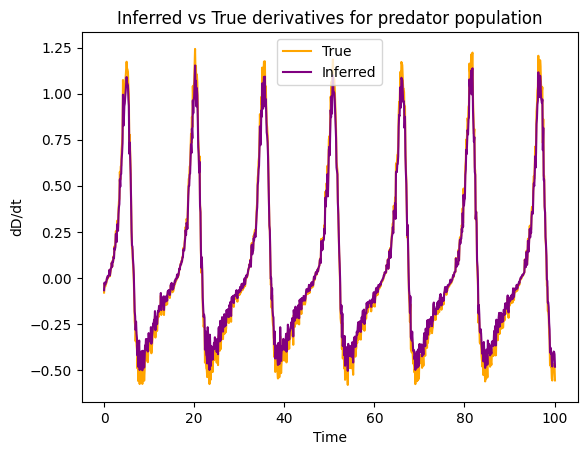

In [20]:
# plot the true and inferred derivatives
p = p_test
d = d_test
y_sol = eval(str(eq_pred))

plt.figure()
plt.plot(t_test, der_test[1], "orange", label="True")
plt.plot(t_test, y_sol, "purple", label="Inferred")
plt.xlabel("Time")
plt.ylabel("dD/dt")
plt.title("Inferred vs True derivatives for predator population")
plt.legend()
plt.show()



Quite good some of the extreme values are not captured, but the general trend is there.

#### Problem 1b:

Take two best performing equations, one for prey (you can use the one given by us above) and one for predators (your result from problem 1a), and simulate a new dataset using the inferred model parameters from the two equations. Plot the results and compare them to the original simulated data in one plot.

Hint: use **generate_LV_samples** function without noise and parameterize it according to the results.

As a reference, Lotka-Volterra functional forms used here are as follows:

$\frac{dP}{dt} = \beta_1 P - \beta_2 PD$

$\frac{dD}{dt} = -\beta_3 D + \beta_4 PD$

#### Code and answers:

In [21]:
#get the two best equations
eq_prey = simplify(convert_s(eqs_p["Equation"][7]))
eq_pred = simplify(convert_s(eqs_pred["Equation"][0]))

In [22]:
eq_pred

In [23]:
eq_prey

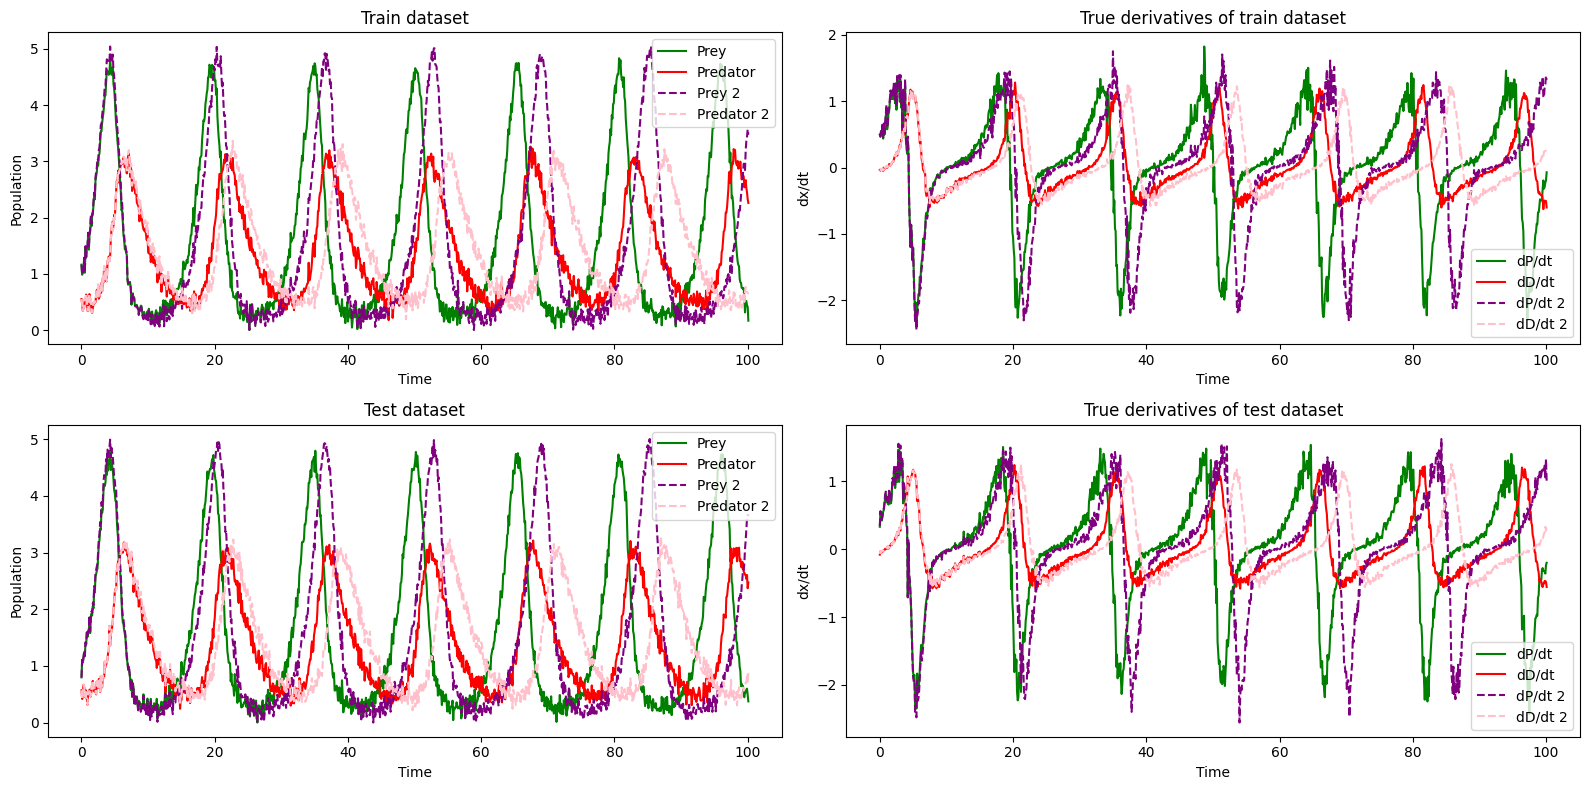

In [24]:
# generate a new simulated dataset using the inferred model parameters from eq_prey and eq_pred
# using the generate_LV_samples function
# changin the b1, b2, b3, b4, t0, p0, d0
np.random.seed(1)
max_time = 100
dt = 0.1
b1 = 0.72
b2 = 0.509 
b3 = 1.466 * 0.182
b4 = 0.182
t0 = 0
p0 = 1
d0 = 0.5

# here we generate the data for the train and test datasets
t_train_2, p_train_2, d_train_2 = generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0)
t_test_2, p_test_2, d_test_2 = generate_LV_samples(max_time, dt, b1, b2, b3, b4, t0, p0, d0)

# we also calculate the true derivatives for the train and test datasets

der_train_2 = derivative(p_train_2, d_train_2, b1, b2, b3, b4)
der_test_2 = derivative(p_test_2, d_test_2, b1, b2, b3, b4)

# we stack the prey and predator populations to form the input data
# this is done by stacking the prey and predator populations as columns
x_train_2 = np.vstack([p_train_2, d_train_2]).T

x_test_2 = np.vstack([p_test_2, d_test_2]).T

# plot the true and inferred derivatives
plt.subplots(2, 2, figsize=(16, 8))

plt.subplot(221)
plt.plot(t_train, p_train, 'green', label="Prey")
plt.plot(t_train, d_train, 'red', label="Predator")
plt.plot(t_train_2, p_train_2, 'purple', label="Prey 2", linestyle="--")
plt.plot(t_train_2, d_train_2, 'pink', label="Predator 2", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Train dataset")

plt.subplot(222)
plt.plot(t_train, der_train[0], 'green', label="dP/dt")
plt.plot(t_train, der_train[1], 'red', label="dD/dt")
plt.plot(t_train_2, der_train_2[0], 'purple', label="dP/dt 2", linestyle="--")
plt.plot(t_train_2, der_train_2[1], 'pink', label="dD/dt 2", linestyle="--")
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.title("True derivatives of train dataset")

plt.subplot(223)
plt.plot(t_test, p_test, 'green', label="Prey")
plt.plot(t_test, d_test, 'red', label="Predator")
plt.plot(t_test_2, p_test_2, 'purple', label="Prey 2", linestyle="--")
plt.plot(t_test_2, d_test_2, 'pink', label="Predator 2", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Test dataset")

plt.subplot(224)
plt.plot(t_test, der_test[0], 'green', label="dP/dt")
plt.plot(t_test, der_test[1], 'red', label="dD/dt")
plt.plot(t_test_2, der_test_2[0], 'purple', label="dP/dt 2", linestyle="--")
plt.plot(t_test_2, der_test_2[1], 'pink', label="dD/dt 2", linestyle="--")

plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.title("True derivatives of test dataset")
plt.tight_layout()
plt.show()



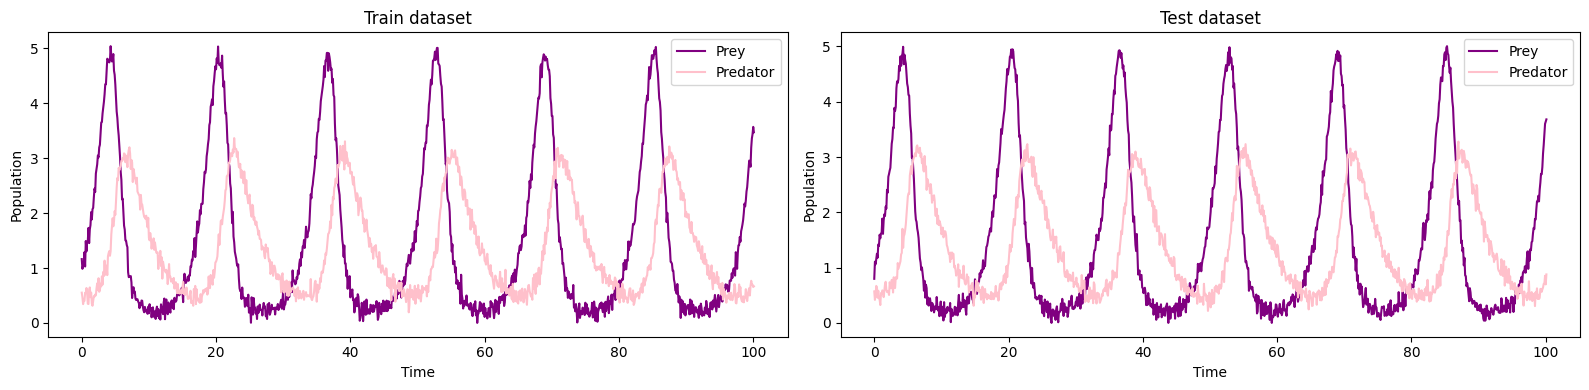

In [25]:
# plot also only the second dataset
plt.subplots(1, 2, figsize=(16, 4))

plt.subplot(121)
plt.plot(t_train_2, p_train_2, 'purple', label="Prey")
plt.plot(t_train_2, d_train_2, 'pink', label="Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Train dataset")

plt.subplot(122)
plt.plot(t_test_2, p_test_2, 'purple', label="Prey")
plt.plot(t_test_2, d_test_2, 'pink', label="Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.title("Test dataset")
plt.tight_layout()
plt.show()


#### Problem 1c:

Plot two scatterplots comparing the values of true (x-axis) and predicted data (y-axis) from problem 1b and compute the coefficient of determination $R^2$, for both prey and predator fits. Keep both axes equal. Judging from these plots and the ones from problem 1b, as well as the $R^2$ statistics, what do you think about the goodness of fit? Is there any systematic over- or underestimation in predictions?

#### Code and answers:

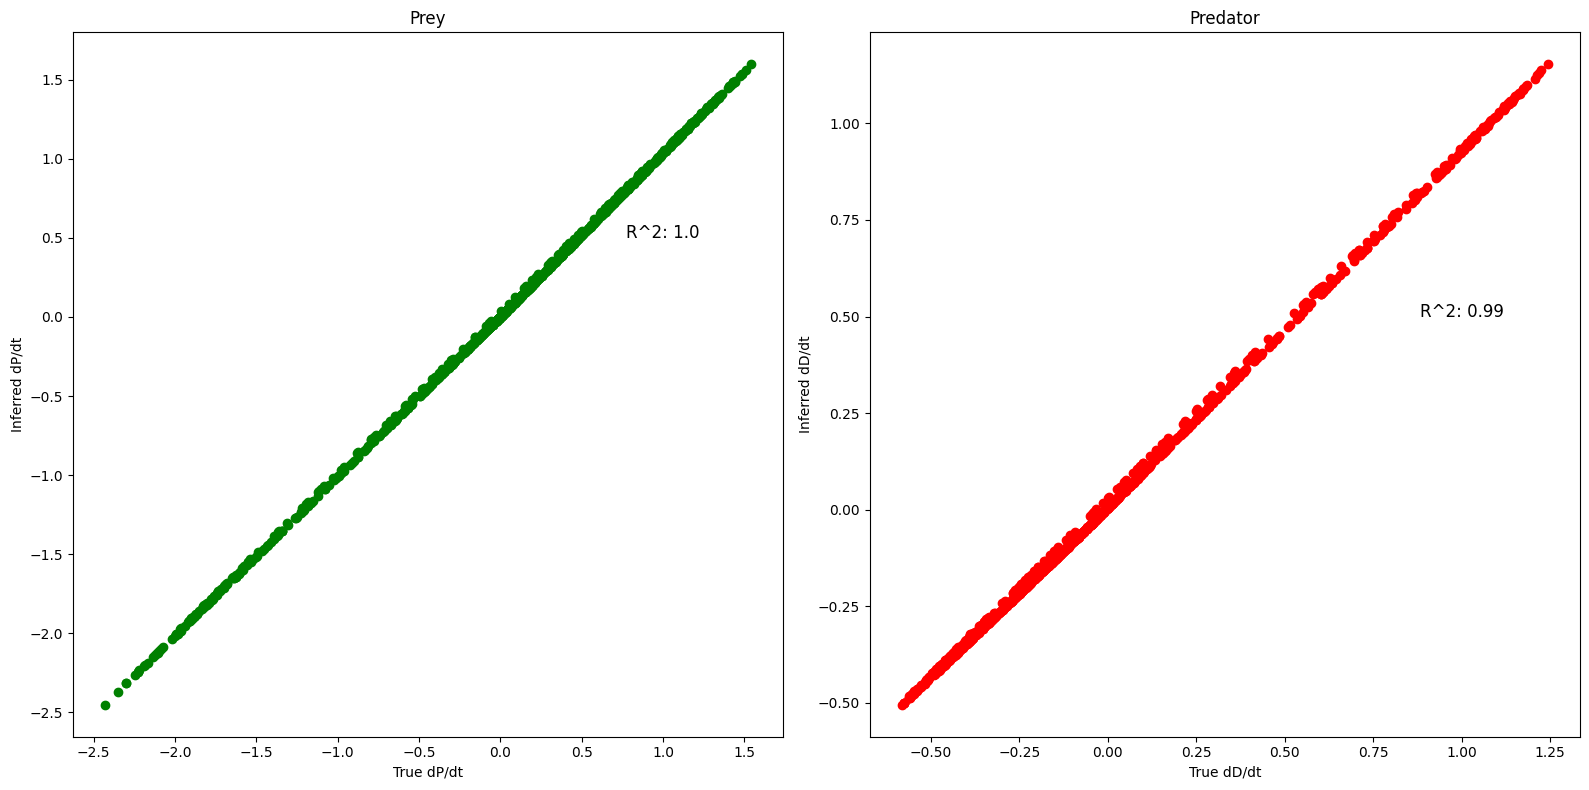

In [35]:
# Plot two scatterplots comparing the values of true (x-axis) and predicted data (y-axis) 
# from problem 1b keep the both axes x,y the same

plt.subplots(1, 2, figsize=(16, 8))

plt.subplot(121)
plt.scatter(der_test[0], eval(str(eq_prey)), color="green")
plt.xlabel("True dP/dt")
plt.ylabel("Inferred dP/dt")
# add the R^2 score to the plot
plt.text(1, 0.5, "R^2: " + str(np.round(r2_score(der_test[0], eval(str(eq_prey))), 2)), fontsize=12, ha='center')

plt.title("Prey")

plt.subplot(122)
plt.scatter(der_test[1], eval(str(eq_pred)), color="red")
plt.xlabel("True dD/dt")
plt.ylabel("Inferred dD/dt")
plt.title("Predator")
# add the R^2 score to the plot
plt.text(1, 0.5, "R^2: " + str(np.round(r2_score(der_test[1], eval(str(eq_pred))), 2)), fontsize=12, ha='center')
plt.tight_layout()
plt.show()







For the Prey the model is very good wiht R^2 being 1 and the scatterplot showing a perfect fit. For the Predator the model is not as good with R^2 being 0.99 and the scatterplot showing a good fit but not perfect. There is some overestimation in the predictions which shows in the plot as dots appearing above the line.

### Problem 2: symbolic regression on real prey-predator data

Let's take a look how SR performs on real data. Here, we have population estimates for the prey (Paramecium) and the predator (Didinium), as well as their partial derivatives with respect to each. The data is from Martin *et al.* https://doi.org/10.1098/rspb.2018.0422

In [36]:
data = pd.read_csv("ParameciumDidinium.csv")
data.head()

,Time,Paramecium (P),Didinium (D),dP/dt,dD/dt
0,0.00,16.461657,5.231674,73.941543,5.044667
1,0.52,51.735546,9.080719,53.958991,12.538306
2,1.01,73.831098,19.266671,47.755918,29.827758
3,1.54,99.913867,39.434318,36.776017,43.867604
4,2.04,104.651751,60.569484,-20.284770,35.862136


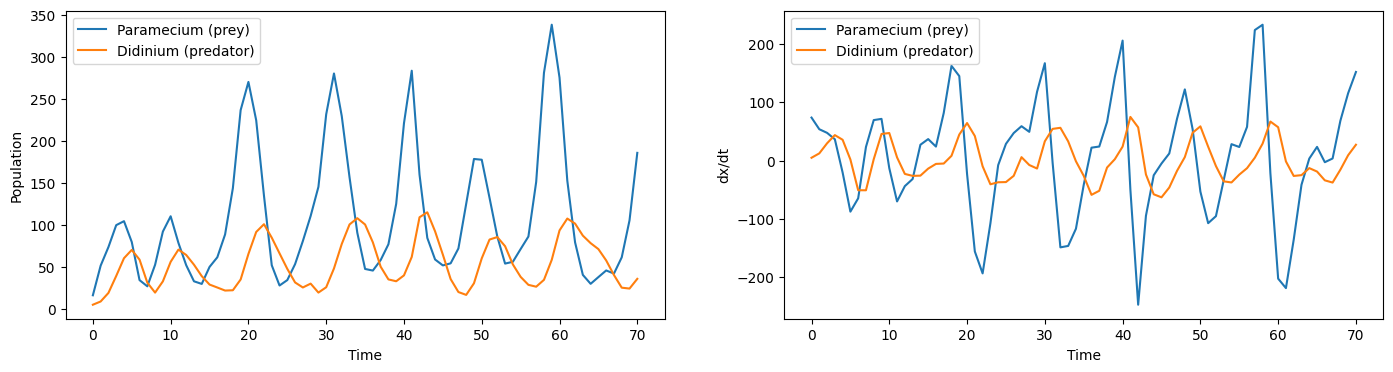

In [37]:
plt.subplots(1, 2, figsize=(17, 4))
plt.subplot(121)
plt.plot(data["Paramecium (P)"], label="Paramecium (prey)")
plt.plot(data["Didinium (D)"], label="Didinium (predator)")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()

plt.subplot(122)
plt.plot(data["dP/dt"], label="Paramecium (prey)")
plt.plot(data["dD/dt"], label="Didinium (predator)")
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.legend()
plt.show()

#### Problem 2a:

Try to find symbolic equations for both prey and predator data using the SR function. Real data is expected to be a more difficult problem, as the real prey-predator dynamics are not necessarily following the exact simplified Lotka-Volterra equations presented in this notebook or they may simply be too noisy.

Evaluate and visualize the best performing equations like in the previous problems. Are any equations representative of the Lotka-Volterra formulas discussed above, either for prey, predator or both? Are their fits reasonably good in terms of their $R^2$ and value-to-value scatterplots?

There is no need to find exact representations (though it can be done), as the search might be time-prohibitive, therefore it's enough to try few instances.

Hint: if the equations SR finds are very long, try increasing the parsimony coefficient (pc in SR function) until the equations are sufficiently compact.

#### Code and answers:

In [41]:
# finding the derivatives of the prey and predator populations
X = data[['Paramecium (P)', 'Didinium (D)']].values
y_p = data['dP/dt'].values
y_d = data['dD/dt'].values


In [42]:
# get the equation using the symbolic regressor from 10 different runs
# first let's get the equation for the prey population
eqs_p = SR(X, y_p, X, y_p, n=10, rng=range(10), method="grow", pc=0.001)
eqs_p


Model 1, R^2 score: 0.78, mul(add(add(add(add(add(add(div(p, d), div(d, 0.407)), div(div(add(div(d, 0.407), div(div(add(mul(d, add(d, p)), add(d, -0.868)), p), 0.962)), add(div(div(div(div(0.132, -0.881), add(-0.500, -0.620)), mul(0.065, -0.196)), div(div(add(p, div(p, d)), add(div(p, d), div(d, 0.407))), mul(0.065, -0.196))), add(add(d, p), p))), mul(0.065, -0.196))), add(add(add(p, div(d, 0.407)), div(div(p, d), mul(0.065, -0.196))), div(d, mul(d, div(d, mul(mul(add(add(add(add(add(add(div(p, d), d), div(div(add(p, div(div(add(mul(d, add(d, p)), div(div(p, d), mul(0.065, -0.196))), p), 0.962)), add(div(div(div(d, add(-0.500, -0.620)), mul(0.065, -0.196)), mul(mul(d, d), div(d, p))), add(add(d, p), p))), mul(0.065, -0.196))), add(add(add(p, div(d, 0.407)), div(div(p, d), mul(0.065, -0.196))), div(d, mul(d, div(d, mul(add(d, 0.251), div(p, d))))))), div(mul(-0.258, d), 0.797)), div(0.994, mul(0.065, -0.196))), mul(div(p, d), div(add(add(add(add(add(div(p, d), div(d, 0.407)), div(0.994,

,Test R^2,Length,Equation
0,0.78,321,"mul(add(add(add(add(add(add(div(p, d), div(d, ..."
1,0.86,69,"add(mul(mul(p, d), -0.025), add(p, add(div(add..."
2,0.84,179,"add(add(mul(0.382, add(p, mul(0.892, p))), mul..."
3,0.84,225,"add(div(add(mul(add(p, d), p), mul(div(d, mul(..."
4,0.76,249,"add(div(-0.924, add(mul(mul(div(p, d), add(add..."
5,0.86,143,"add(add(div(p, add(add(div(p, add(add(add(add(..."
6,0.86,171,"add(div(add(-0.930, p), mul(d, 0.075)), add(di..."
7,0.85,231,"mul(div(div(div(div(p, 0.446), div(p, p)), add..."
8,0.86,145,"mul(mul(p, add(add(add(div(0.555, 0.061), d), ..."
9,0.85,43,"div(add(div(d, mul(0.073, d)), mul(add(d, div(..."


In [44]:
# then get the equation for the predator population
eqs_pred = SR(X, y_d, X, y_d, n=10, rng=range(10), method="grow", pc=0.001)
eqs_pred

Model 1, R^2 score: 0.68, add(add(div(add(add(add(d, p), div(add(d, add(add(mul(p, d), mul(d, 0.040)), -0.193)), add(div(d, div(mul(add(p, d), add(p, d)), 0.200)), div(mul(add(div(d, p), mul(0.608, d)), d), mul(div(d, p), add(0.284, p)))))), div(div(mul(add(0.582, d), add(p, d)), 0.200), add(add(add(0.246, -0.351), 0.870), add(add(div(div(d, add(mul(mul(-0.389, p), add(d, p)), mul(mul(-0.389, p), add(0.582, d)))), p), div(div(mul(add(p, d), add(p, d)), 0.200), add(div(add(d, add(div(d, div(mul(0.139, p), div(0.502, add(div(add(p, 0.001), add(mul(mul(-0.389, p), add(d, p)), 0.870)), add(div(p, add(p, -0.308)), div(p, 0.910)))))), -0.193)), add(div(d, mul(add(add(div(-0.014, p), 0.800), 0.800), -0.351)), div(mul(div(p, 0.891), d), mul(div(d, p), add(0.284, p))))), mul(mul(-0.389, p), add(d, p))))), mul(add(mul(div(d, mul(p, 0.510)), div(0.104, div(p, -0.948))), p), 0.213))))), add(mul(p, d), mul(d, 0.040))), div(div(mul(add(0.582, d), add(p, d)), 0.200), add(add(div(div(d, d), mul(p, -0.

,Test R^2,Length,Equation
0,0.68,221,"add(add(div(add(add(add(d, p), div(add(d, add(..."
1,0.68,219,"mul(0.114, add(add(div(add(add(-0.129, d), add..."
2,0.74,273,"add(mul(0.382, add(p, div(d, -0.868))), mul(ad..."
3,0.70,405,"add(add(-0.286, div(mul(add(-0.286, div(mul(mu..."
4,0.67,129,"add(mul(add(add(0.519, d), div(div(-0.562, -0...."
5,0.72,121,"add(mul(div(mul(div(-0.076, p), mul(0.397, p))..."
6,0.68,301,"mul(add(div(add(add(div(p, mul(mul(0.012, d), ..."
7,0.67,285,"div(add(mul(add(-0.810, -0.736), mul(d, d)), a..."
8,0.72,141,"add(mul(div(d, add(add(mul(p, mul(p, -0.113)),..."
9,0.73,277,"add(div(mul(add(mul(add(mul(p, 0.154), d), div..."


Quite good results with the R^2 but the equations are quite long and not very readable. Let's try to increase the parsimony coefficient to see if we can get a more readable equation.

Parsimony coefficient: 0.02
Predator:
Model 1, R^2 score: 0.68, add(mul(0.202, add(add(mul(0.199, p), add(mul(0.199, p), div(div(mul(add(add(p, d), p), add(div(add(add(div(d, 1.000), add(0.848, 0.460)), -0.040), 0.957), p)), 0.200), add(p, mul(mul(-0.389, p), add(d, p)))))), p)), div(div(mul(add(0.582, d), add(p, d)), 0.200), add(mul(-0.104, add(add(add(0.246, -0.351), 0.870), mul(mul(-0.389, p), add(add(mul(-0.104, div(p, -0.489)), add(add(0.246, -0.351), 0.870)), 0.870)))), mul(mul(-0.389, p), add(0.582, d)))))
Model 2, R^2 score: 0.67, add(add(div(div(add(p, d), div(-0.062, p)), mul(p, add(0.545, p))), add(add(add(mul(p, 0.056), mul(0.665, div(0.631, -0.062))), add(mul(p, 0.056), add(mul(p, 0.056), mul(0.665, div(0.631, -0.062))))), mul(p, -0.938))), p)
Model 3, R^2 score: 0.61, add(mul(0.382, add(p, div(d, -0.868))), mul(add(div(p, 0.155), -0.456), div(div(-0.851, d), div(add(p, div(d, -0.868)), div(div(div(-0.851, d), div(d, d)), p)))))
Model 4, R^2 score: 0.69, add(add(mul(-0.408

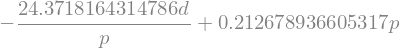

In [52]:
# lets try getting the functions to be shorter by increasing the parsimony coefficient

# let's go through few different parsimony coefficients
# set seed for reproducibility
np.random.seed(1)
predator_eqs = {}
prey_eqs = {}
parsimony_coefficients = [0.02, 0.04 ,0.1]
for i in parsimony_coefficients:
    print("Parsimony coefficient: " + str(i))
    print("Predator:")
    predator_eqs[i] = SR(X, y_d, X, y_d, n=10, rng=range(10), method="grow", pc=i)
    print("Prey:")
    prey_eqs[i] = SR(X, y_p, X, y_p, n=10, rng=range(10), method="grow", pc=i)


# get the best equations for the prey and predator populations
eq_prey = simplify(convert_s(prey_eqs[0.1]["Equation"][0]))
eq_pred = simplify(convert_s(predator_eqs[0.1]["Equation"][0]))

eq_prey

eq_pred

    

In [60]:
predator_eqs[0.1]

,Test R^2,Length,Equation
0,0.64,13,"add(mul(-0.104, div(p, -0.489)), div(d, mul(mu..."
1,0.59,11,"add(mul(p, mul(0.001, p)), div(-0.829, mul(0.0..."
2,0.61,17,"add(mul(0.382, add(p, div(d, -0.868))), mul(ad..."
3,0.62,17,"add(mul(0.180, p), add(mul(0.180, p), div(div(..."
4,0.66,19,"add(mul(div(div(add(d, d), add(-0.581, 0.657))..."
5,0.68,19,"div(add(div(div(div(d, 0.244), -0.341), d), ad..."
6,0.64,17,"add(mul(0.178, p), div(add(mul(d, 0.944), d), ..."
7,0.65,29,"add(div(add(mul(add(-0.810, -0.736), mul(d, d)..."
8,0.67,19,"add(add(div(div(d, -0.072), div(mul(d, p), add..."
9,0.68,31,"add(div(-0.525, 0.041), add(add(div(-0.525, 0...."


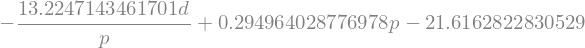

In [61]:
eq_prey = simplify(convert_s(prey_eqs[0.1]["Equation"][1]))
eq_pred = simplify(convert_s(predator_eqs[0.1]["Equation"][5]))

eq_prey

eq_pred


In [62]:
# simplify all the equations
p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in prey_eqs[0.1]["Equation"]:
    print(simplify(convert_s(eq)))

for eq in predator_eqs[0.1]["Equation"]:
    print(simplify(convert_s(eq)))


-2.35437581874928*d + 104.239164619165 + 6.85436893203884*p/d
p*(0.534*p + (1 - 0.025*d)*(d + p))/(d + p)
(-d*(0.369*d - 0.631*p)*(0.858*d + 0.738*p) - 0.080442*d + (0.369*d - 0.631*p)*(37.2689326177698*d + 36.0763267740012*p + 4.0384633273703))/(d*(0.369*d - 0.631*p))
(d*(-0.014076*d*(d + p) + 0.621*d + 0.575*p) + 12.5*d + 12.5*p)/d
(d*p**2 + (19.2872727272727*d**2 + 0.624*p**2)*(-0.022*d*p - 0.576*d + 1.04776*p + 31.9090909090909))/(19.2872727272727*d**2 + 0.624*p**2)
-0.00868852459016393*d**2 - 0.0173770491803279*d*p + 7.19424460431655*d/p + 9.8282030113614*d/p**2 + p + 17.5671538198013 + 8.09824460431655/p - 0.0457553956834532/p**2
-1.11358574610245*d - 0.315*p + 0.29295 + 1/(0.001*p - 0.00093) + 75.0/p + 26.6666666666667*(p - 0.93)/d
-3.24215246636771*d*(0.00787727444593472*d*p - 0.601034567930542*p + 0.0741652615443571)/(d - (0.435*p - 1.6012213471259)/p) - 0.435*p - 0.975336322869955*p/(d + d/p)
p*(d*(0.293367346938776 - 0.01341657595*d) + 20.0080032012805)/d
(-1.41843971631206*

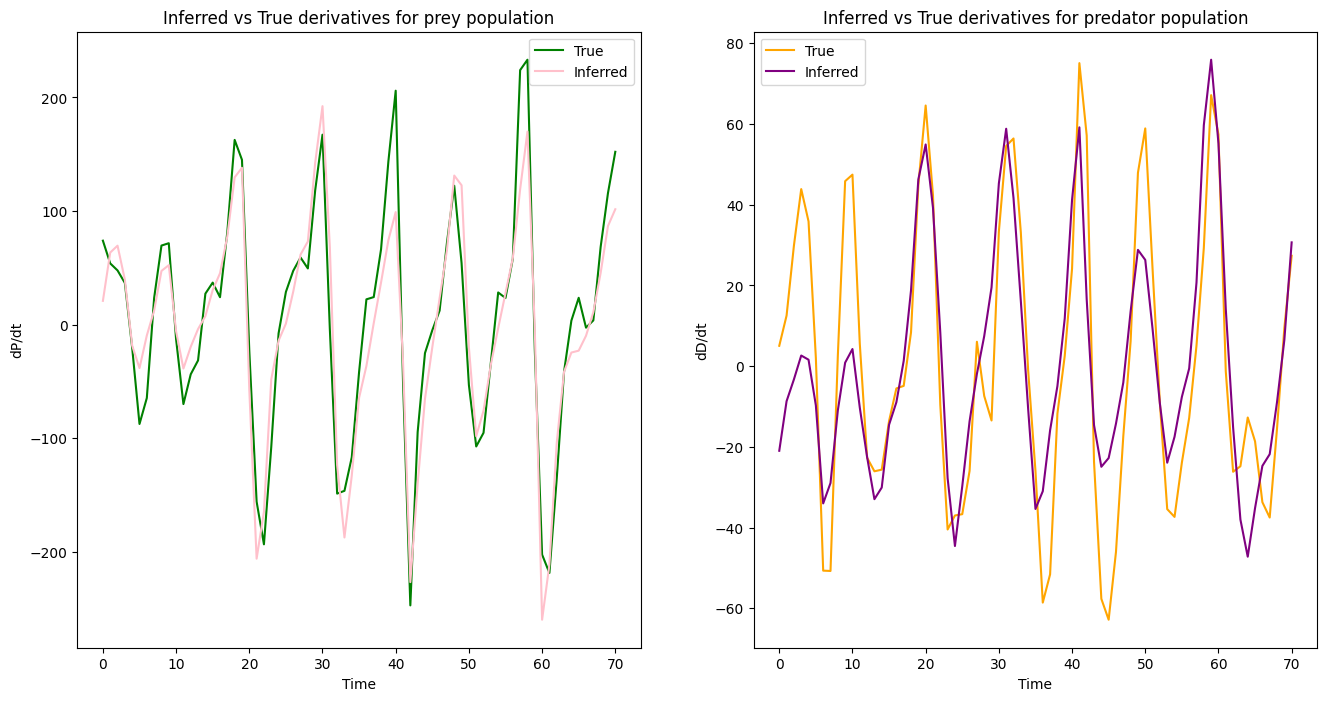

In [63]:
# plot the true and inferred derivatives
p = data["Paramecium (P)"].values
d = data["Didinium (D)"].values
y_sol_p = eval(str(eq_prey))
y_sol_d = eval(str(eq_pred))

plt.subplots(1, 2, figsize=(16, 8))

plt.subplot(121)
plt.plot(data["dP/dt"], "green", label="True")
plt.plot(y_sol_p, "pink", label="Inferred")
plt.xlabel("Time")
plt.ylabel("dP/dt")
plt.title("Inferred vs True derivatives for prey population")
plt.legend()

plt.subplot(122)
plt.plot(data["dD/dt"], "orange", label="True")
plt.plot(y_sol_d, "purple", label="Inferred")
plt.xlabel("Time")

plt.ylabel("dD/dt")
plt.title("Inferred vs True derivatives for predator population")
plt.legend()
plt.show()


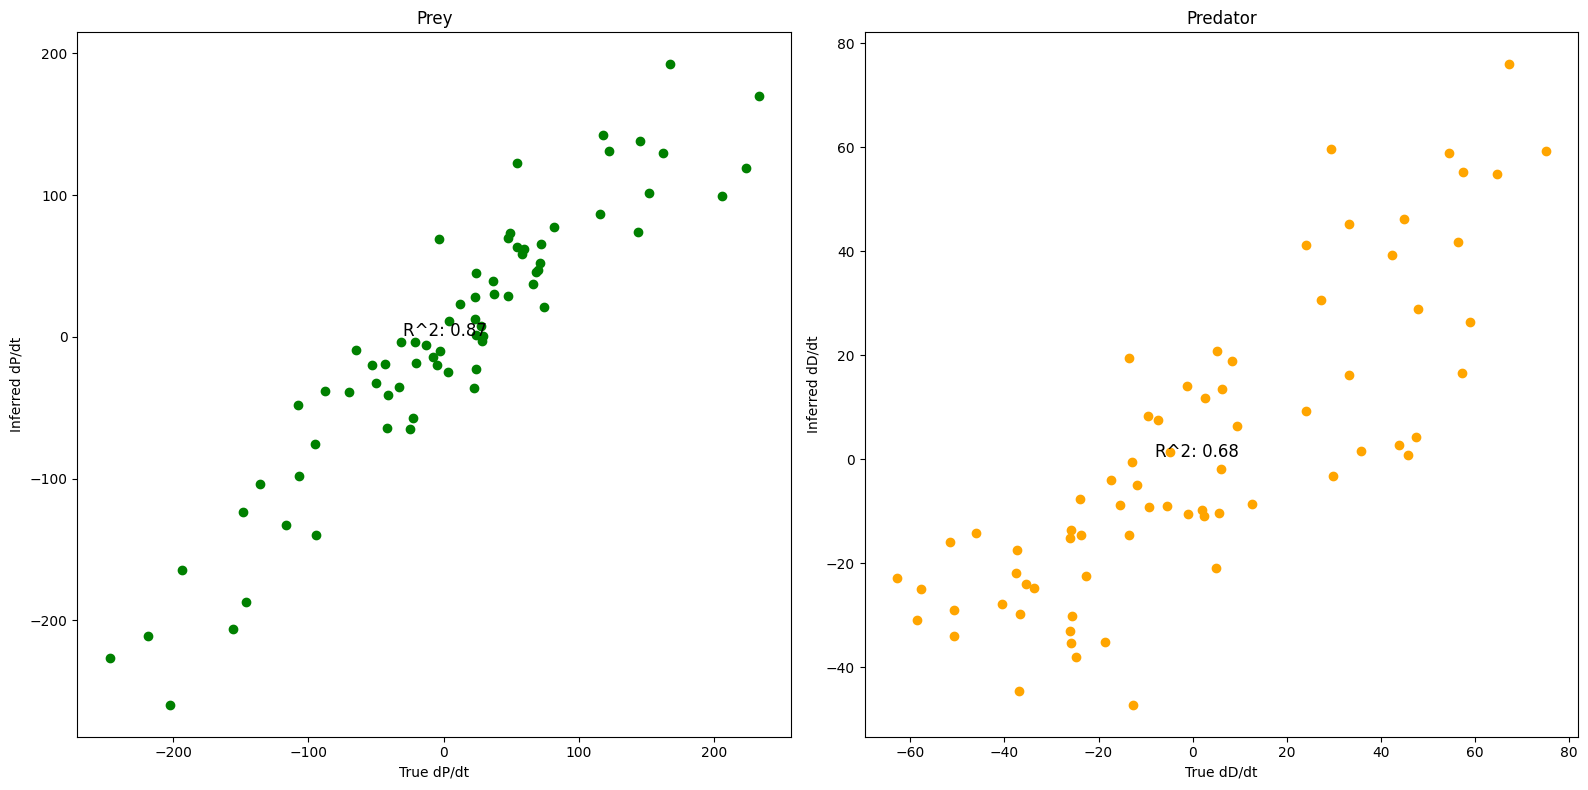

In [64]:
# Plot two scatterplots comparing the values of true (x-axis) and predicted data (y-axis) 

plt.subplots(1, 2, figsize=(16, 8))

plt.subplot(121)
plt.scatter(data["dP/dt"], y_sol_p, color="green")
plt.xlabel("True dP/dt")
plt.ylabel("Inferred dP/dt")
# add the R^2 score to the plot
plt.text(1, 0.5, "R^2: " + str(np.round(r2_score(data["dP/dt"], y_sol_p), 2)), fontsize=12, ha='center')


plt.title("Prey")

plt.subplot(122)
plt.scatter(data["dD/dt"], y_sol_d, color="orange")
plt.xlabel("True dD/dt")
plt.ylabel("Inferred dD/dt")
plt.title("Predator")
# add the R^2 score to the plot
plt.text(1, 0.5, "R^2: " + str(np.round(r2_score(data["dD/dt"], y_sol_d), 2)), fontsize=12, ha='center')
plt.tight_layout()
plt.show()


Quite good results although the R^2 is not as good as before. The equations are more readable after simplyfying them and the parsimony coefficient is 0.1.

I'll try splitting the data using test_train_split and then running the symbolic regression on the training data. I'll then evaluate the best performing equation on the test data.

In [48]:
# split the data into train and test datasets
X_train, X_test, y_p_train, y_p_test, y_d_train, y_d_test = train_test_split(X, y_p, y_d, test_size=0.2, random_state=1)

# get the equation using the symbolic regressor from 10 different runs
# first let's get the equation for the prey population
eqs_p = SR(X_train, y_p_train, X_test, y_p_test, n=10, rng=range(10), method="grow", pc=0.1)
eqs_p

# then get the equation for the predator population
eqs_pred = SR(X_train, y_d_train, X_test, y_d_test, n=10, rng=range(10), method="grow", pc=0.1)
eqs_pred

# simplify all the equations
p, d = symbols('p d')
init_printing(use_unicode=True)
for eq in eqs_p["Equation"]:
    print(simplify(convert_s(eq)))

for eq in eqs_pred["Equation"]:
    print(simplify(convert_s(eq)))

# the equation with the highest R^2 score and the shortest length


Model 1, R^2 score: 0.74, mul(add(add(add(add(add(add(div(d, 0.578), d), div(0.994, mul(0.065, -0.196))), mul(0.065, -0.196)), p), add(add(div(p, d), div(d, 0.407)), div(div(p, d), mul(0.065, -0.196)))), div(d, mul(-0.413, mul(p, 0.016)))), -0.390)
Model 2, R^2 score: 0.62, add(add(mul(mul(p, d), -0.025), add(p, mul(mul(-0.597, d), 0.871))), mul(0.573, p))
Model 3, R^2 score: 0.39, add(add(div(d, -0.648), add(mul(div(add(d, p), -0.842), 0.086), div(add(p, d), mul(d, 0.086)))), div(add(d, add(d, p)), mul(d, 0.078)))
Model 4, R^2 score: 0.55, add(add(div(add(div(d, -0.890), div(add(p, p), mul(0.080, add(d, 0.905)))), p), add(div(d, -0.890), div(add(p, p), mul(0.080, add(d, 0.905))))), add(add(div(0.694, d), mul(div(-0.800, d), mul(d, p))), div(div(add(add(p, d), p), mul(d, 0.194)), div(mul(0.571, p), add(p, d)))))
Model 5, R^2 score: 0.52, add(div(-0.924, mul(div(d, p), mul(d, p))), add(div(d, div(-0.980, div(p, p))), mul(add(add(d, d), add(add(d, p), div(p, 0.997))), div(div(add(p, d), 